[INFO] loading images...


C:\Users\Windows\AppData\Local\Temp\ipykernel_22140\3829303452.py:88: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


[INFO] compiling model...
[INFO] training model...
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.9688 - loss: 0.1308 - val_accuracy: 0.9820 - val_loss: 0.0736
Epoch 2/20
 1/90 ━━━━━━━━━━━━━━━━━━━━ 1:08 771ms/step - accuracy: 1.0000 - loss: 0.0106

C:\Users\Windows\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step - accuracy: 1.0000 - loss: 0.0106 - val_accuracy: 0.9820 - val_loss: 0.0737
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9825 - loss: 0.0821 - val_accuracy: 0.9820 - val_loss: 0.0656
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - accuracy: 1.0000 - loss: 0.0147 - val_accuracy: 0.9820 - val_loss: 0.0654
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9828 - loss: 0.0757 - val_accuracy: 0.9820 - val_loss: 0.0609
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - accuracy: 0.9688 - loss: 0.1111 - val_accuracy: 0.9820 - val_loss: 0.0609
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9835 - loss: 0.0569 - val_accuracy: 0.9820 - val_loss: 0.0533
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.9375 - loss: 0.2348 - val_accuracy: 0.9820 - val_loss: 0.0532
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9839 - loss: 0.0553 - val_accuracy: 0.9820 - val_

                precision    recall  f1-score   support

   with_helmet       0.75      0.23      0.35        13
without_helmet       0.99      1.00      0.99       709

      accuracy                           0.98       722
     macro avg       0.87      0.61      0.67       722
  weighted avg       0.98      0.98      0.98       722

[INFO] saving helmet detector model...


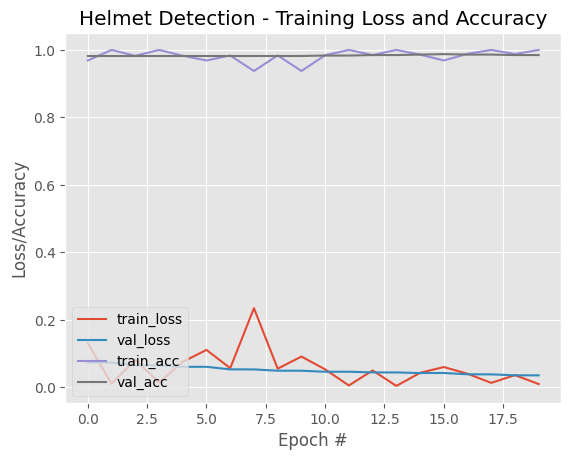

In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize training parameters
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# 🔹 CHANGE DATASET PATH HERE
DIRECTORY = r"D:\AI learing\Deep Learining Week 11\helmet dedation\dataset"

# 🔹 CHANGE CATEGORY NAMES
CATEGORIES = ["with_helmet", "without_helmet"]

print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
    
        # Skip non-image files
        if not img.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
    
        try:
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)
    
            data.append(image)
            labels.append(category)
    
        except Exception as e:
            print(f"[WARNING] Skipping corrupted file: {img_path}")
            continue
            image = preprocess_input(image)
    
            data.append(image)
            labels.append(category)

# one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(
    data, labels,
    test_size=0.20,
    stratify=labels,
    random_state=42)

# Data Augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# Load MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

# Build Head Model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze base layers
for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

# Train model
print("[INFO] training model...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# Evaluate
print("[INFO] evaluating model...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(
    testY.argmax(axis=1),
    predIdxs,
    target_names=lb.classes_))

# Save model
print("[INFO] saving helmet detector model...")
model.save("helmet_detector.h5")

# Plot training results
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Helmet Detection - Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("helmet_plot.png")